In [3]:
BASE_PATH = "/content/drive/MyDrive/archive/Dataset_Filtered"
CLASSES = ["Edible", "poisonous"]
IMG_SIZE = (224, 224)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import random
import tensorflow as tf

CLASSES = ["Edible", "poisonous"]
BASE_PATH = "/content/drive/MyDrive/archive/Dataset_Filtered"
IMG_SIZE = (224, 224)

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img / 255.0

def generate_episode(k_shot=5, query_class=0):
    support_images, support_labels = [], []
    query_image, query_label = None, None

    for label, cls in enumerate(CLASSES):
        class_dir = os.path.join(BASE_PATH, cls)
        species_list = os.listdir(class_dir)
        selected_species = random.sample(species_list, min(3, len(species_list)))

        total_imgs_needed = k_shot
        imgs_collected = 0

        for species in selected_species:
            species_path = os.path.join(class_dir, species)
            img_files = os.listdir(species_path)
            sample_count = min(len(img_files), max(1, total_imgs_needed // len(selected_species)))

            sampled_imgs = random.sample(img_files, sample_count)
            for img_file in sampled_imgs:
                img_path = os.path.join(species_path, img_file)
                support_images.append(load_image(img_path))
                support_labels.append(label)
                imgs_collected += 1

            if imgs_collected >= k_shot:
                break

        if label == query_class:
            query_species = random.choice([s for s in species_list if s not in selected_species])
            query_dir = os.path.join(class_dir, query_species)
            query_file = random.choice(os.listdir(query_dir))
            query_path = os.path.join(query_dir, query_file)
            query_image = load_image(query_path)
            query_label = label

    return {
        "support_images": tf.stack(support_images),
        "support_labels": tf.convert_to_tensor(support_labels),
        "query_image": query_image,
        "query_label": tf.convert_to_tensor(query_label)
    }


In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
#Running EfficentNetB0 as our Base Model
def get_embedding_model():
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base.layers[-30:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128)(x)
    return models.Model(base.input, x)

embedding_model = get_embedding_model()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
import numpy as np
#Calculating the accuracy and loss per epoch using 20 images per class and 200 eposides
optimizer = tf.keras.optimizers.Adam(1e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

train_losses = []
train_accuracies = []

for epoch in range(1, 6):
    epoch_loss = []
    epoch_acc = []

    for step in range(200):
        episode = generate_episode(k_shot=20)
        with tf.GradientTape() as tape:
            support_emb = embedding_model(episode['support_images'])
            query_emb = embedding_model(tf.expand_dims(episode['query_image'], axis=0))

            support_emb = tf.math.l2_normalize(support_emb, axis=1)
            query_emb = tf.math.l2_normalize(query_emb, axis=1)

            support_labels = episode["support_labels"]
            proto_edible = tf.reduce_mean(tf.boolean_mask(support_emb, support_labels == 0), axis=0)
            proto_poison = tf.reduce_mean(tf.boolean_mask(support_emb, support_labels == 1), axis=0)
            prototypes = tf.stack([proto_edible, proto_poison])

            distances = tf.reduce_sum(tf.square(prototypes - query_emb), axis=1)
            probs = tf.nn.softmax(-distances)

            true_label = tf.expand_dims(episode['query_label'], 0)
            loss = loss_fn(true_label, tf.expand_dims(probs, 0))

        grads = tape.gradient(loss, embedding_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, embedding_model.trainable_variables))

        pred = tf.argmax(probs).numpy()
        acc = 1.0 if pred == episode['query_label'].numpy() else 0.0
        epoch_loss.append(loss.numpy())
        epoch_acc.append(acc)

    print(f"Epoch {epoch} - Loss: {np.mean(epoch_loss):.4f}, Accuracy: {np.mean(epoch_acc):.4f}")


Epoch 1 - Loss: 0.6931, Accuracy: 0.5250
Epoch 2 - Loss: 0.6932, Accuracy: 0.4950
Epoch 3 - Loss: 0.6930, Accuracy: 0.5750
Epoch 4 - Loss: 0.6931, Accuracy: 0.5650
Epoch 5 - Loss: 0.6931, Accuracy: 0.6350


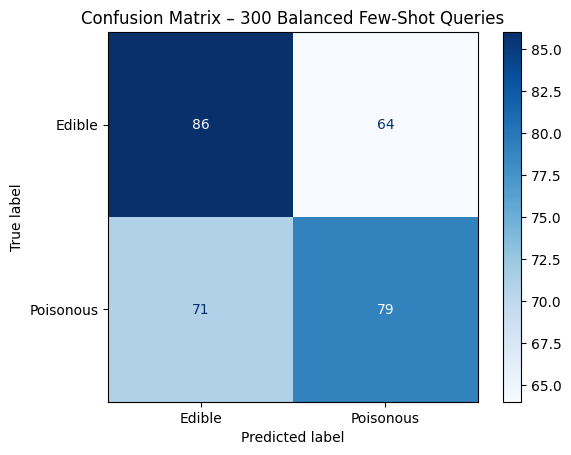

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []

queries_per_class = 150

for target_label in [0, 1]:
    for _ in range(queries_per_class):
        episode = generate_episode(k_shot=20, query_class=target_label)

        support_emb = embedding_model(episode['support_images'])
        query_emb = embedding_model(tf.expand_dims(episode['query_image'], axis=0))

        support_emb = tf.math.l2_normalize(support_emb, axis=1)
        query_emb = tf.math.l2_normalize(query_emb, axis=1)

        support_labels = episode["support_labels"]
        proto_edible = tf.reduce_mean(tf.boolean_mask(support_emb, support_labels == 0), axis=0)
        proto_poison = tf.reduce_mean(tf.boolean_mask(support_emb, support_labels == 1), axis=0)
        prototypes = tf.stack([proto_edible, proto_poison])

        distances = tf.reduce_sum(tf.square(prototypes - query_emb), axis=1)
        probs = tf.nn.softmax(-distances)
        pred = tf.argmax(probs).numpy()

        true_labels.append(target_label)
        predicted_labels.append(pred)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Edible", "Poisonous"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – 300 Balanced Few-Shot Queries")
plt.show()
